## Aprendizaje automático II. Pytorch
___

### 1. Autogradientes de PyTorch
---
En nuestro pequeñó experimento, vimos un ejemplo simple de propagación hacia atrás (_backpropagation_), el cálculo del gradiente de una composición de funciones (_model_ y _loss_) con respecto a sus parámetros (_w_ y _b_) mediante la propagación hacia atrás de sus derivadas parciales.

Incluso aunque tuviéramos un modelo complicado con millones de parámetros, mientras el modelo sea diferenciable, definir el cálculo del gradiente de la función del error medido respecto de los parámetros no es más que un proceso analítico que debemos hacer una única vez. Eso sí, un proceso extremadamente aburrido y lento.

Aquí es cuando PyTorch viene, de nuevo, al rescate con un componente denominado **_autograd_**. 

Los tensores de PyTorch pueden "recordar" de dónde proceden, es decir qué operaciones y tensores previos los originaron, y pueden proporcionar de forma automática la cadena de derivadas de dichas operaciones con respecto a sus entradas. Esto significa que ya no necesitamos derivar nuestro modelo _"a mano"_.

#### 1.1 Aplicando _autograd_
---
Vamos a recuperar nuestro modelo anterior del termómetro. Usaremos sobre él _autograd_ y veremos qué pasa.

Primero, recuperamos el _dataset_...

In [1]:
import torch

# temperaturas ºC
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]

# temperaturas en escala desconocida (unknown)
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

y ahora nuestras funciones de modelo y pérdida...

In [2]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    return ((t_c - t_p)**2).mean()

Vamos a inicializar nuevamente nuestro tensor de parámetros pero, en este caso, le indicaremos a PyTorch (opción _requires_\__grad_) que haga un seguimiento y registro de todas las operaciones (y tensores resultantes) que realicemos sobre el tensor. En caso de que dichas operaciones sean diferenciables, el valor de la derivada estará automáticamente disponible en el atributo **_grad_** del tensor.

In [3]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
params.grad is None 

True

Ahora, lo que único que tenemos que hacer es calcular el modelo sobre unos datos de entrada, aplicar nuestra función de pérdida (_loss_, en nuestro caso, _MCE_) para computar la diferencia con respecto al valor esperado. Finalmente, invocar **_backward_** en el tensor resultante, de forma que el atributo _grad_ de _params_ contenga las derivadas de la función de pérdida respecto a cada elemento de parámetros.

In [4]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

A partir del tensor original (_params_), PyTorch va creando un grafo con las diferentes operaciones realizadas sobre el tensor que, como resultado, producirán nuevos tensores. Cuando se invoca la función **_backward()_** sobre estos nuevos tensores, PyTorch atraviesa el grafo en orden inverso calculando las derivadas paraciales de las diferentes operaciones realizadas.

NOTA: _backward_ sólo puede realizarse sobre tensores escalares (como ECM, cuyo resultado es un escalar)

<br>

![](data/image-lect/grad.png)

<br>

#### 1.4 Reescribiendo nuestro bucle de entrenamiento
---
Vamos a reescribir nuestro bucle de entrenamiento. Nos apoyaremos en esta funcionalidad de PyTorch para calcular las derivadas parciales de la función de pérdida respecto a los parámetros y actualizar sus valores.

Dado que las operaciones de _backward_ son acumulativas, deberemos tmar la precaución de "resetear" a 0 el gradiente del tensor antes de cada iteración


In [5]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=False):
    t_params_list = torch.zeros([n_epochs, 2])
    t_loss_list = torch.zeros(n_epochs)
    
    for epoch in range(1, n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
                
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()   # sustituimos la llamada a nuestras funciones de derivación
        
        # update parameters
        with torch.no_grad():  # deshabilitamos autograd para operar con params
            params -= learning_rate * params.grad
        
        # almacenamos los resultado de cada época para analizar
        t_loss_list[epoch-1] = loss
        t_params_list[epoch-1] = params # new params learned
        
        if print_params:
            print(f'Epoch {epoch}: loss {loss:.3f}')  
            print(f'\tParams:\t{params}:\n\tGrad:\t{grad}')         
    
    return t_loss_list, t_params_list

Veamos si funciona...

In [6]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
t_un = (t_u - t_u.mean())/t_u.std()
t_loss, t_params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = params,
    t_u = t_un,
    t_c = t_c)
print(t_loss[-1], t_params[-1])

tensor(2.9276, grad_fn=<SelectBackward>) tensor([ 9.0349, 10.5000], grad_fn=<SelectBackward>)


El mismo resultado!! Ya no necesitamos calcular derivadas a mano!!

#### 1.5 Optimizadores
---
Existen diversas estrategis de optimización y "trucos" que pueden facilitar la convergencia, especialmente cuando tratamos con modelos complicados.

PyTorch proporciona a través del módulo **_optim_** diferentes algoritmos de optimización que nos facilitan la tarea de actualización de los parámetros en cada iteración de entrenamiento, ahorrándonos el trabajo de hacerlo por nosotros mismos.

In [7]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_multi_tensor',
 'functional',
 'lr_scheduler',
 'swa_utils']

El constructor de cada uno de los optimizadores anteriores tomará una lista de parámetros como entrada (un tensor con el atributo _requires_\__grad_ a _True_. Los parámetros serán mantenidos dentro del optimizador de forma que pueda actualizarlos y acceder al atributo _grad_.

<br>

![](data/image-lect/optimizer.png)

<br>

Cada optimizador expone dos métodos, _zero_\__grad_ y _step. _zero_\__grad_ "resetea" a 0 el atributo _grad_ de todos los parámetros recibidos. _step_ actualiza los valores de los parámetros de acuerdo a la estrategia de optimización seleccionada.

Veamos con un ejemplo:

In [11]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

_SGD_ significa _stochastic gradient descent_. El términoc _stochastic_ hace referencia a que  calcula el gradiente promediando sobre un _subset_ aleatorio de las muestras del _dataset_ (_minibatch_). 

En todo caso, el optimizador no sabe si está evaluando la función de pérdida sobre todo el _dataset_ o un subconjunto.

Vamos a probarlo sobre nuestro _dataset_

In [14]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

El valor de _params_ se ha actualizado después de invocar _step_ automáticamente! Del mismo modo que hacía nuestro código "a mano".

Antes de modificar nuestra función de entrenamiento, debemos recordar inicializar a 0 nuestros gradientes o, de lo contrario, se acumularán en cada iteración del bucle cada vez que llamemos a _backward()_.

Finalmente, nuestra función para el entrenamiento quedará de la siguiente manera:

In [15]:
def training_loop(n_epochs, optimizer, params, t_u, t_c, print_params=False):
    t_params_list = torch.zeros([n_epochs, 2])
    t_loss_list = torch.zeros(n_epochs)
    
    for epoch in range(1, n_epochs+1):
        t_p = model(t_u, *params) # aplica el modelo al dataset
        loss = loss_fn(t_p, t_c)  # calcula el error

        optimizer.zero_grad()  # inicializa los gradientes
        loss.backward()        # calcula los gradientes
        optimizer.step()       # actualiza los parámetros
        
        # almacenamos los resultado de cada época para analizar
        t_loss_list[epoch-1] = loss
        t_params_list[epoch-1] = params # new params learned
        
        if print_params:
            print(f'Epoch {epoch}: loss {loss:.3f}')  
            print(f'\tParams:\t{params}:\n\tGrad:\t{grad}')         
    
    return t_loss_list, t_params_list

Y procederemos a entrenar nuestro modelo como siempre (fíjate que se pasa el _dataset_ normalizado)

In [24]:
t_un = 0.1*t_u
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_loss, t_params = training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

err = t_loss[-1].item()
w,b = t_params[-1]
print(f'error: {err:.3f}; [w = {w:.3f}, b = {b:.3f}]')

error: 2.928; [w = 5.367, b = -17.301]


##### Probando otros optimizadores (ADAM)
---
Podemos probar fácilmente otros optimizadores. Basta con crear una nueva instancia del optimizador seleccionado y pasárselo a la función de entrenamiento.

Por ejemplo, vamos a usar **_Adam_**. Este optimizador, más sofisticado que _SGD_, usa un _learning rate_ adaptativo y, por tanto, es menos sensible al escalado de los parámetros. Por ejemplo, vamos a emplearlo sobre los datos sin normalizar y con un _learnning rate_ de un orden de magnitud superior:



In [26]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1 # learning rate mayor
optimizer = optim.Adam([params], lr=learning_rate) # Optimizador Adam

t_loss, t_params = training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_u, # _dataset_ sin normalizar
    t_c = t_c)

err = t_loss[-1].item()
w,b = t_params[-1]
print(f'error: {err:.3f}; [w = {w:.3f}, b = {b:.3f}]')

error: 2.928; [w = 0.537, b = -17.305]


El mismo resultado!!!!

#### 1.6 Entrenamiento, validación y _overfitting_
---
Como hemos visto, cuando diseñamos y entrenamos un modelo, básicamente estamos buscando los valores de una serie de parámetros que nos permitan **_aproximar_** una determinada función, lo que nos permitirá hacer predicciones futuras a partir de datos de entrada no vistos durante el entrenamiento.

Cuando nuestro modelo es extremandamente flexible y adaptable, como el proporcionado por las redes neuronales profundas, podemos _virtualmente_ aproximar cualquier función. Es decir, estos modelos de múltiples parámetros son capaces de ajustarse de forma que la pérdida sea mínima en las muestras del _dataset_ de entrenamiento. Pero esto no nos garantiza que el comportamiento del modelo sea correcto con muestras "desconocidas" o "no vistas" previamente, lo que invalidaría su uso como predictor. Este fenómeno es lo que se conoce como **_overfitting_**. El modelo ha sido capaz de predecir perfectamente los resultados esperados en el _dataset_ de entrenamiento, ajustando los parámetros hasta minimizar las pérdidas al máximo, pero con un comportamiento muy pobre con datos nuevos.

<br>

![](data/image-lect/overfitting.png)

<br>

Un fenómeno contrario es el denominado **_underfitting_**. En este caso, no conseguimos disminuir la pérdida con el entrenamiento. Esto puede ser debido a dos razones fundamentales:

1. El modelo es demasiado simple (pocos parámetros) y no consigue aproximar la función 
2. El _dataset_ de entrenamiento es pobre, bien porque contiene pocas muestras o porque los datos contenidos no aportan suficiente información para "descubrir" relaciones


##### _Training_\__set_ y _Validation_\__set_
---
Con objeto de poder validar el comportamiento de nuestro modelo, antes de proceder a sus entrenamiento, deberemos dividir el _dataset_ original (de forma aleatoria) en dos conjuntos independientes: el **_training_\__set_** y el **_validation_\__set_**

Como su nombre indica, el primero lo utilizaremos para entrenar el modelo, mientra que el segundo sólo se utilizará para evaluar sus predicciones sobre conjuntos de datos no vistos previamente, lo que nos dará una idea de su comportamiento real. 

<br>

![data/image-lect/split.png](data/image-lect/split.png)

<br>

Generalmente, el _validation_\__set_ suele tener un tamaño en torno al 20% del _dataset_ original.

Podemos hacer la división del _dataset_ fácilmente creando un vector con los índices del _dataset_ ordenados al azar (_torch.randperm_) y emplearlo para extraer dos subconjuntos diferenciados.

In [48]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

Una vez creados los dos conjuntos de índices, los usaremos para construir los dos nuevos _datasets_ a partir del original.

In [49]:
# training dataset
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

# validation dataset
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

# normalization (if necessary)
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

Ahora procederíamos a entrenar nuestro modelo sobre el _training_\__dataset_ para, posteriormente, una vez determinados los parámetros, evaluar su rendimiento sobre el _validation_\__dataset_

Dado que nuestra función de entrenamiento nos devuelve los parámetros de cada iteración, podemos evaluar cada época y ver como se ha ido decreciendo el error en el _validation_\__dataset_ (esto mismo lo podíamos hacer añadiendo la validación dentro del bucle de entrenamiento y devolviendo un nuevo valor, el _error_ en el _validation_\__dataset_)

In [50]:
# Training
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_loss, t_params = training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = train_t_un,   # training data (samples)
    t_c = train_t_c)    # training data (labels)

err = t_loss[-1].item()
w,b = t_params[-1]
print(f'error: {err:.3f}; [w = {w:.3f}, b = {b:.3f}]')

error: 2.733; [w = 5.315, b = -17.421]


In [54]:
# Validation
t_val_loss = torch.zeros(t_params.size()[0])
with torch.no_grad(): # podemos deshabilitar el cálculo de gradientes (nota final)
    for i, params in enumerate(t_params):
        val_t_p = model(val_t_un, *params)
        t_val_loss[i] = loss_fn(val_t_p, val_t_c)
    
err = t_val_loss[-1].item()
print(f'error: {err:.3f};')

error: 4.672;


Como podemos observar, existe una pequeña discrepancia entre el error final _training_\__set_ y en el _validation_\__set_. Este error, como es lógico, siempre será mayor en la validación. De todas formas, lo que realmente nos importa es ver que el error vaya descendiendo a lo largo del proceso de entrenamiento.

Vamos a imprimir la evolución de ambos errores (en el _training_\__set_ y en el _validation_\__set_)

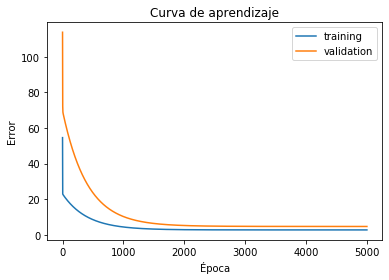

In [55]:
from matplotlib import pyplot as plt
t_x = torch.arange(t_loss.size()[0])
plt.plot(t_loss.detach().numpy(), label = 'training') # detach().numpy() porque tiene gradientes
plt.plot(t_val_loss, label = 'validation') # no tiene gradientes. No necesitamos convertirlo
plt.title(f"Curva de aprendizaje")
plt.ylabel("Error")
plt.xlabel("Época")
plt.legend()
plt.show()

Aunque el ejemplo propuesto no es muy representativo, pues el _validation_\__set_ es demasiado pequeño, podemos apreciar el descenso en ambos _datasets_ a medida que avanza el entrenamiento.

El estudio de estas gráficas comparadas es tremendamente útil, tal como podemos apreciar en la siguiente imagen. Nos permitirá, tanto observar comportamientos ideales (C) o aceptables (D), como detectar fácilmente situaciones de _underfitting_ (A) como de _overfitting_ (B).

<br>

![data/image-lect/train_vs_val_loss.png](data/image-lect/train_vs_val_loss.png)

<br>


##### NOTA: Autograd switch off
---
Una pequeña nota final sobre el proceso anterior de evaluación. Debemos tener presente que se van a crear dos grafos independientes a partir de _params_.

<br>

![data/image-lect/params_graph.png](data/image-lect/params_graph.png)

<br>

Dado que sólo entrenamos sobre el _training_\__set_, sólo vamos a realizar _backpropagation_ en las operaciones sobre este _set_. Por tanto, no necesitamos el segundo grafo para nada y podemos desactivar _autograd_ haciendo uso de _torch.no_\__grad_ en la validación

